In [1]:
import os 
import random
import csv
import pandas as pd
import numpy as np

In [2]:
def read_csv(file_path):
    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        data = list(reader)
    return data

In [3]:
data = pd.read_csv('Housing.csv')
print(data.head())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


## Feature handling

Some feature like the furnishing status has 3 types of status (furnished,semi-furnished,unfurnished). 
What we can do is make it into a binary column by using one-hot encoding. This means, we set the furnished as a base class, this means we drop the furnished, and set the semi-furnished and unfurnished as an individual columns included in the features. If it is furnished, semi-furnished and unfurnished is 0.

In [4]:
y = data['price'].values.reshape(-1, 1)
x = pd.get_dummies(data, columns=['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea','furnishingstatus'], drop_first=True)
x = x.drop(columns=['price'])
print(x[:5])


   area  bedrooms  bathrooms  stories  parking  mainroad_yes  guestroom_yes  \
0  7420         4          2        3        2          True          False   
1  8960         4          4        4        3          True          False   
2  9960         3          2        2        2          True          False   
3  7500         4          2        2        3          True          False   
4  7420         4          1        2        2          True           True   

   basement_yes  hotwaterheating_yes  airconditioning_yes  prefarea_yes  \
0         False                False                 True          True   
1         False                False                 True         False   
2          True                False                False          True   
3          True                False                 True          True   
4          True                False                 True         False   

   furnishingstatus_semi-furnished  furnishingstatus_unfurnished  
0      

In [5]:
print(x.columns)

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_yes',
       'guestroom_yes', 'basement_yes', 'hotwaterheating_yes',
       'airconditioning_yes', 'prefarea_yes',
       'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished'],
      dtype='object')


## Correlation Analysis

Before we proceed with the training, lets analyze our dataset first and see the correlation between all the features and its prices. 

In [6]:
corr = x.copy()
corr['price'] = y
corr_matrix = corr.corr(numeric_only=True)['price'].sort_values(ascending=False)

print(corr_matrix)

price                              1.000000
area                               0.535997
bathrooms                          0.517545
airconditioning_yes                0.452954
stories                            0.420712
parking                            0.384394
bedrooms                           0.366494
prefarea_yes                       0.329777
mainroad_yes                       0.296898
guestroom_yes                      0.255517
basement_yes                       0.187057
hotwaterheating_yes                0.093073
furnishingstatus_semi-furnished    0.063656
furnishingstatus_unfurnished      -0.280587
Name: price, dtype: float64


## Mutual information analysis

It captures non-linear relationships.

In [7]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(x, corr['price'])
mi_scores = pd.Series(mi, index=x.columns).sort_values(ascending=False)
print(mi_scores)

area                               0.192511
stories                            0.145448
bathrooms                          0.143378
parking                            0.130755
bedrooms                           0.120860
airconditioning_yes                0.116313
mainroad_yes                       0.084738
furnishingstatus_unfurnished       0.076870
guestroom_yes                      0.074781
prefarea_yes                       0.060624
furnishingstatus_semi-furnished    0.059410
basement_yes                       0.047335
hotwaterheating_yes                0.017092
dtype: float64


In [8]:
corr_features = corr_matrix.index[1:11].tolist()
print(corr_features)

['area', 'bathrooms', 'airconditioning_yes', 'stories', 'parking', 'bedrooms', 'prefarea_yes', 'mainroad_yes', 'guestroom_yes', 'basement_yes']


In [9]:
mi_features = mi_scores.index[:10].tolist()
print("\nSelected top 10 features based on MI:", mi_features)


Selected top 10 features based on MI: ['area', 'stories', 'bathrooms', 'parking', 'bedrooms', 'airconditioning_yes', 'mainroad_yes', 'furnishingstatus_unfurnished', 'guestroom_yes', 'prefarea_yes']


In [10]:
x_corr = x[corr_features].copy()
x_mi = x[mi_features].copy()
print(x_corr.head())

   area  bathrooms  airconditioning_yes  stories  parking  bedrooms  \
0  7420          2                 True        3        2         4   
1  8960          4                 True        4        3         4   
2  9960          2                False        2        2         3   
3  7500          2                 True        2        3         4   
4  7420          1                 True        2        2         4   

   prefarea_yes  mainroad_yes  guestroom_yes  basement_yes  
0          True          True          False         False  
1         False          True          False         False  
2          True          True          False          True  
3          True          True          False          True  
4         False          True           True          True  


## Standardize Continuous columns

Standardization (Z-score) scales the data such that it has a mean of 0 and a standard deviation of 1. You only need to apply this to the continuous columns.

The formula for standardization is:

$$X_(norm)= \frac{X-\mu}{\sigma} $$

where $\mu$ is the mean and the $\sigma$ is the standard deviation for that column.

In [11]:
continuous_cols = ["area"]

mean = x_corr[continuous_cols].mean()
std  = x_corr[continuous_cols].std()

print("Mean:", mean)
print("Standard Deviation:\n", std)


x_corr[continuous_cols] = (x_corr[continuous_cols] - mean) / std

Mean: area    5150.541284
dtype: float64
Standard Deviation:
 area    2170.141023
dtype: float64


In [12]:
mean = x_mi[continuous_cols].mean()
std  = x_mi[continuous_cols].std()

print("Mean:", mean)
print("Standard Deviation:\n", std)


x_mi[continuous_cols] = (x_mi[continuous_cols] - mean) / std

Mean: area    5150.541284
dtype: float64
Standard Deviation:
 area    2170.141023
dtype: float64


## Binary Columns

Convert columns that uses binary classification yes/no or true/false to be 1/0. The columns that we will convert is mainroad, guestroom, basement, hotwaterheating,airconditioning, furnishingstatussemi-furnished, and furnishingstatusunfurnished

In [13]:
for col in corr_features:
    if col in continuous_cols:
        continue
    if x_corr[col].dtype == object:
        x_corr[col] = x_corr[col].map({"yes": 1, "no": 0, "Yes": 1, "No": 0})
    else:
        x_corr[col] = x_corr[col].astype(int)

In [14]:
for col in mi_features:
    if col in continuous_cols:
        continue
    if x_mi[col].dtype == object:
        x_mi[col] = x_mi[col].map({"yes": 1, "no": 0, "Yes": 1, "No": 0})
    else:
        x_mi[col] = x_mi[col].astype(int)

## Splitting Training and Test set

Using a random seed of 42, we split the dataset to 70-30 for training and test set.

In [15]:
combined = list(zip(x_corr.values, y))
random.seed(42)
random.shuffle(combined)

split = int(0.7 * len(combined))
train_set, test_set = combined[:split], combined[split:]

train_texts, train_labels = zip(*train_set)
test_texts, test_labels = zip(*test_set)

x_train_corr = np.array(train_texts)
x_test_corr = np.array(test_texts)
y_train_corr = np.array(train_labels)
y_test_corr = np.array(test_labels)

In [16]:
combined = list(zip(x_mi.values, y))
random.seed(42)
random.shuffle(combined)

split = int(0.7 * len(combined))
train_set, test_set = combined[:split], combined[split:]

train_texts, train_labels = zip(*train_set)
test_texts, test_labels = zip(*test_set)

x_train_mi = np.array(train_texts)
x_test_mi = np.array(test_texts)
y_train_mi = np.array(train_labels)
y_test_mi = np.array(test_labels)

In [17]:
print("Correlation: ",x_corr[0:2])
print("Mutual Information: ",x_mi[0:2])

Correlation:         area  bathrooms  airconditioning_yes  stories  parking  bedrooms  \
0  1.045766          2                    1        3        2         4   
1  1.755397          4                    1        4        3         4   

   prefarea_yes  mainroad_yes  guestroom_yes  basement_yes  
0             1             1              0             0  
1             0             1              0             0  
Mutual Information:         area  stories  bathrooms  parking  bedrooms  airconditioning_yes  \
0  1.045766        3          2        2         4                    1   
1  1.755397        4          4        3         4                    1   

   mainroad_yes  furnishingstatus_unfurnished  guestroom_yes  prefarea_yes  
0             1                             0              0             1  
1             1                             0              0             0  


In [18]:
print(y_train_mi[0:2])

[[6090000]
 [6300000]]


# Training the dataset

Using gradient descent we will try to do linear regression model

In [19]:
X_train_corr = np.c_[np.ones((x_train_corr.shape[0], 1)), x_train_corr]
theta_corr = np.zeros((X_train_corr.shape[1], 1))
Y_train_corr = y_train_corr.reshape(-1, 1)
m = len(Y_train_corr)

In [20]:
X_train_mi = np.c_[np.ones((x_train_mi.shape[0], 1)), x_train_mi]
theta_mi = np.zeros((X_train_mi.shape[1], 1))
Y_train_mi = y_train_mi.reshape(-1, 1)
m = len(Y_train_mi)

In [21]:
def compute_cost(X, Y, theta):
    max_epochs = 10000
    tolerance = 1e-6
    learning_rate = 1e-3
    prev_cost = float('inf')

    for epoch in range(max_epochs):
        r = X.dot(theta) - Y
        gradients = (1/m) * X.T.dot(r)
        theta -= learning_rate * gradients

        cost = (1/(2*m)) * np.sum(r**2)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Cost: {cost}")

        if abs(prev_cost - cost) < tolerance:
            print(f"Converged at epoch {epoch}")
            break
        prev_cost = cost
    return theta


In [22]:
theta_corr = compute_cost(X_train_corr, Y_train_corr, theta_corr)
print(theta_corr.flatten().tolist())

Epoch 0, Cost: 13029900336870.078
Epoch 1000, Cost: 782513412536.0226
Epoch 2000, Cost: 722048393975.7604
Epoch 3000, Cost: 696500497766.5892
Epoch 4000, Cost: 680657587752.4656
Epoch 5000, Cost: 670031202467.2819
Epoch 6000, Cost: 662763435172.9507
Epoch 7000, Cost: 657737437387.6808
Epoch 8000, Cost: 654226038657.333
Epoch 9000, Cost: 651746353219.531
[434828.0466093296, 546970.1604385523, 966497.75416319, 708597.1672226733, 496061.69101378514, 372745.68675770896, 329513.7110194238, 544682.0819031895, 490123.7830868627, 244471.92680696442, 342762.5854838868]


In [23]:
theta_mi = compute_cost(X_train_mi, Y_train_mi, theta_mi)
print(theta_mi.flatten().tolist())

Epoch 0, Cost: 13029900336870.078
Epoch 1000, Cost: 790614898847.5983
Epoch 2000, Cost: 727163163512.5314
Epoch 3000, Cost: 699611099452.2156
Epoch 4000, Cost: 682111789859.6746
Epoch 5000, Cost: 670152151404.4971
Epoch 6000, Cost: 661834260973.9813
Epoch 7000, Cost: 655988422000.2283
Epoch 8000, Cost: 651835852539.8691
Epoch 9000, Cost: 648849360582.5249
[505591.08571121487, 521063.8524698028, 435585.980730563, 981771.803559394, 363673.8488485278, 393390.8896789661, 713072.2149739707, 524311.1961296787, -307902.2772484649, 326429.1723219383, 571505.6795061926]


In [24]:
def test_model(X, Y, theta):
    Y_pred = X.dot(theta)

    # Metrics
    mse = np.mean((Y_pred - Y) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(Y_pred - Y))
    
    ss_total = np.sum((Y - np.mean(Y)) ** 2)
    ss_res = np.sum((Y - Y_pred) ** 2)
    r2 = 1 - (ss_res / ss_total)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Predictions": Y_pred
    }

In [25]:
X_test_corr = np.c_[np.ones((x_test_corr.shape[0], 1)), x_test_corr]
Y_test_corr = y_test_corr.reshape(-1, 1)

In [26]:
results_corr = test_model(X_test_corr, Y_test_corr, theta_corr)
print(f"Test MSE: {results_corr['MSE']}")
print(f"Test RMSE: {results_corr['RMSE']}")
print(f"Test MAE: {results_corr['MAE']}")
print(f"Test R²: {results_corr['R2']}")

Test MSE: 978369996902.5303
Test RMSE: 989125.8751557005
Test MAE: 744053.7706848294
Test R²: 0.6805306900222285


In [27]:
X_test_mi = np.c_[np.ones((x_test_mi.shape[0], 1)), x_test_mi]
Y_test_mi = y_test_mi.reshape(-1, 1)

In [28]:
results_mi = test_model(X_test_mi, Y_test_mi, theta_mi)
print(f"Test MSE: {results_mi['MSE']}")
print(f"Test RMSE: {results_mi['RMSE']}")
print(f"Test MAE: {results_mi['MAE']}")
print(f"Test R²: {results_mi['R2']}")

Test MSE: 1007822282174.4344
Test RMSE: 1003903.5223438727
Test MAE: 769138.4134908658
Test R²: 0.6709135704428542


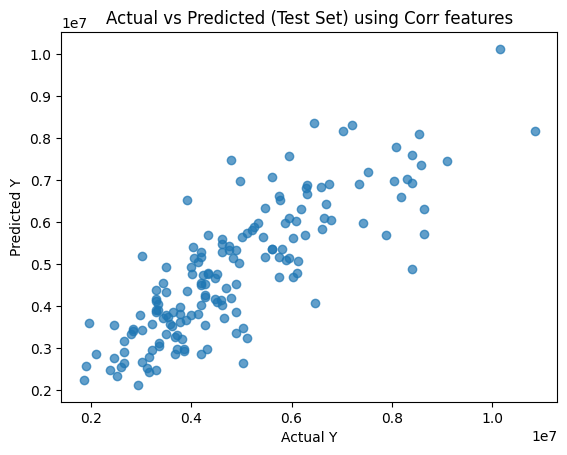

In [29]:
import matplotlib.pyplot as plt

plt.scatter(Y_test_mi, results_mi['Predictions'], alpha=0.7)
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Actual vs Predicted (Test Set) using Corr features")
plt.show()

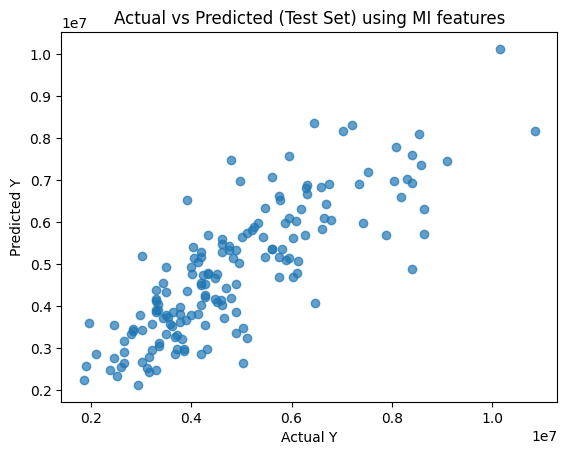

In [30]:
import matplotlib.pyplot as plt

plt.scatter(Y_test_mi, results_mi['Predictions'], alpha=0.7)
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Actual vs Predicted (Test Set) using MI features")
plt.show()